# How to get these notebooks to work

Dataset describe here: http://archive.ics.uci.edu/ml/datasets/Online+Retail+II

wget http://archive.ics.uci.edu/ml/machine-learning-databases/00502/online_retail_II.xlsx

git clone git@github.com:franzoni/proton-Hands-on_task_Senior_Data_Scientist.git

mv online_retail_II.xlsx proton-Hands-on_task_Senior_Data_Scientist

In [1]:
import sys, os
import pandas as pd
import matplotlib.pyplot as plt

data_path = os.getcwd()
print('++ Directory of this notebook:')
print('\t%s'%data_path)

excel_with_path  = data_path+'/online_retail_II.xlsx'
pickle_with_path = data_path+'/online_retail_II.pkl'
csv_with_path    = data_path+'/online_retail_II.csv'

print('\n++Full path of the data file:')
print('\tdata_path =%s\n\n'%excel_with_path)

df = None

if os.path.isfile(pickle_with_path):
    print('-> picke already exists, much faster using it than opening excel files\n')
    df = pd.read_pickle(pickle_with_path)
else:
    print('-> picke does not exist, go to excel, and create it\n')
    df1 = pd.read_excel (excel_with_path,'Year 2009-2010')
    df2 = pd.read_excel (excel_with_path,'Year 2010-2011')
    df = pd.concat([df1, df2])
    df.to_pickle(pickle_with_path)
    print('-> picke done\n')

++ Directory of this notebook:
	/eos/home-f/franzoni/SWAN_projects/proton-Hands-on_task_Senior_Data_Scientist

++Full path of the data file:
	data_path =/eos/home-f/franzoni/SWAN_projects/proton-Hands-on_task_Senior_Data_Scientist/online_retail_II.xlsx


-> picke already exists, much faster using it than opening excel files



In [2]:
# define transaction: total cash for a single 'row' of the dataset, i.e. item_price times the number of items bought
df['Transaction'] = df.Quantity * df.Price
df=df.rename(columns={"Customer ID": "Customer_ID"})

# day, week and time are added for convenience of analysis later on
from datetime import datetime
df['InvoiceDay'] = df['InvoiceDate'].map(lambda p: p.date())
df['InvoiceWeekDay'] = df['InvoiceDate'].map(lambda p: p.weekday())
df['InvoiceTime'] = df['InvoiceDate'].map(lambda p: p.time())
df['InvoiceWeek'] = df['InvoiceDate'].map(lambda p: p.isocalendar()[1]+52*(p.year-2010))

# avoide negative weeks and start counting from the first week of the dataset, which starts from 01/12/2009
df['InvoiceWeek'] = df['InvoiceWeek']+3


# implement the definition of cancellation in the documentation:
# http://archive.ics.uci.edu/ml/datasets/Online+Retail+II
#      ==> "If this code starts with the letter 'c', it indicates a cancellation.""
def is_cancellation(s):
    """" implement the definition of cancellation in the documentation:
          http://archive.ics.uci.edu/ml/datasets/Online+Retail+II
          ==> "If this code starts with the letter 'c', it indicates a cancellation."""
    if isinstance(s, int):
        #print "ordinary invoice"
        return 0
    elif isinstance(s, unicode):
        #print "unicode string"
        #thse are cancellations
        if s.rfind('C')!=-1:
            return 1
        else:
            # print "Something unexpected"  # found, e.g. A506401
            # print s
            return 2
df['IsCancellation'] = df['Invoice'].map(is_cancellation)



max_item_price=1400
r             =(0,max_item_price)
def is_ordinary_item(p):
    """ items with prices above ~1500 are so few that is worth looking at them in detail, and excluding them from the plots
        There'a lot of transactions with price set to 0, which based on the descriptions are """
    if abs(p)>max_item_price or p==0:
        return 0
    else:
        return 1
df['IsOrdinaryItem'] = df['Price'].map(is_ordinary_item)        

# df.to_csv(csv_with_path, encoding = 'utf-8')

<a id="section_EDA_cleaning"></a>
# data cleaning: nan's

In [3]:
# what are the nulls in each feature?
nulls = df.isnull().sum()[df.isnull().sum() != 0]

# select all transactions containing 
df_nulls = df[df.isnull().any(axis=1)].copy(deep=True)

nulls_rel = nulls/df.shape[0]*100

nulls_summary = pd.concat([nulls, nulls_rel], axis=1, keys=['nulls', 'rel. nulls [%]'])\
               .sort_values('nulls', ascending=False)

nulls_summary

,nulls,rel. nulls [%]
Customer_ID,243007,22.766873
Description,4382,0.410541


## todo
- nan and empty -> cleanup   # IN THE MAKING -> only consequences on the users study
- add colums for data and time, separately ?    # DONE
- create a second DF by user: RFM added to


# What do I want to extract from this dataset? WORKING NOTES
- https://en.wikipedia.org/wiki/Exploratory_data_analysis

- how many customers   DONE, also as a function of country
- make a pliot of transaction, of purchase prices, and of invoice_price! #  DONE

- VS TIME: trends of spending overall, by country
- revenue as a function of date, as a function of the time in the day  # DONE
- trends of spending: overall, by the largest customer, by the smaller customers (TOO SPECIFIC?)

- NEED TO BUILD A PER CUSTOMER DF
- customer: how many transactions, how much total revenue:
    => BREAK DOWN BY country, tra
- RMF


- ==> do this
- how many different types of items                  # DONE
- what kind of items are bought the most (by NUMBER of by REVENUE), are cancelled the most, 
- how much revenue per type of item bought

- correlation between
- cancellations: fraction of cancellation by nunber of transactions and by proportion of renenue
-                correlation to CHURNING ? Correlation to country OR type of good purchased ?

- Can I cathegorise the purchasable items? => If so, customers split across those cathegories
- Persona; how many cheap items, few expensive ones?
- https://cxl.com/blog/creating-customer-personas-using-data-driven-research/
- now many items are bought per session, how much is spent per session

==> TOWARDS CUSTOMER PERSONA DEFINITION
- MANY TRANSACTIONS ARE RECORDED AT THE SAME TIME => as if they were a single shopping session, but billed in split goups of goods
- the function summary_data_from_transaction_data treats transactions taking place on the same day as A SINGLE ONE!

<a id="section_customers"></a>
## Customers carachteristics

# Cleanup of data for customer analysis
- we decide to remove all datata points with no Customer_ID
- and to limit the study only to IsOrdinaryItem (as defined above), to avoid skewing the resuts w/ dataa points which are not actual purchases
- to keep the modelling basic, for now we decide also to remove all cancellation oders



In [4]:
df.shape

(1067371, 15)

In [5]:
df=df.dropna()

In [6]:
df.shape

(824364, 15)

In [7]:
df= df.loc[ (df.IsCancellation==0) & (df.IsOrdinaryItem==1) ]    

In [8]:
df.shape

(805520, 15)

In [9]:
df=df.sort_values(by=['InvoiceDate'],ascending=True)

# Basic customer integral features
- number of items bought trgought the entire period covered by data, indicating the overall commercial activity of each individual
- unique items, indicates the variety of the customers interests
- total amount spent by a customer
- number of invoices, i.e. how many times a customers surfaced and made an order

In [10]:
print('There are %d customers in the cleaned dataset'%df['Customer_ID'].nunique() )

There are 5875 customers in the cleaned dataset


# Customer value, diversity of interests, number of transactions and invoices

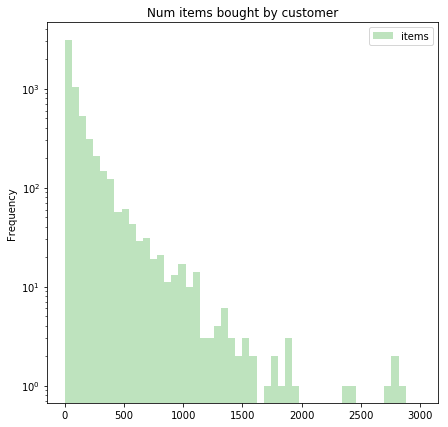

In [11]:
df_customer_items  = df.groupby('Customer_ID').StockCode.agg([len])     \
                         .rename(columns={"len": "items"})               \
                         .sort_values(by=['items'],ascending=False)

tit='Num items bought by customer'
r=(0,3000)
df_customer_items.plot(kind='hist',logy=True,title=tit,bins=50,range=r,colormap='Accent',alpha=0.5,figsize=(7,7))

,uniq_items
count,5875.000000
mean,82.029447
std,116.499880
min,1.000000
25%,19.000000
50%,45.000000
75%,103.000000
max,2550.000000


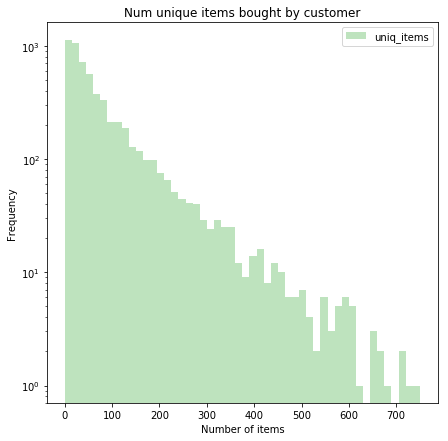

In [12]:
df_customer_uniq_items  = df.groupby('Customer_ID').StockCode.unique().agg([len])     \
                         .rename(columns={"len": "uniq_items"})               \
                         .sort_values(by=['uniq_items'],ascending=False)

tit='Num unique items bought by customer'

r=(0,750)
df_customer_uniq_items.plot(kind='hist',logy=True,title=tit, \
                            bins=50,range=r,colormap='Accent',alpha=0.5,figsize=(7,7))
plt.xlabel('Number of items') 
df_customer_uniq_items.describe()

,invoices
count,5875.000000
mean,6.288511
std,12.994839
min,1.000000
25%,1.000000
50%,3.000000
75%,7.000000
max,396.000000


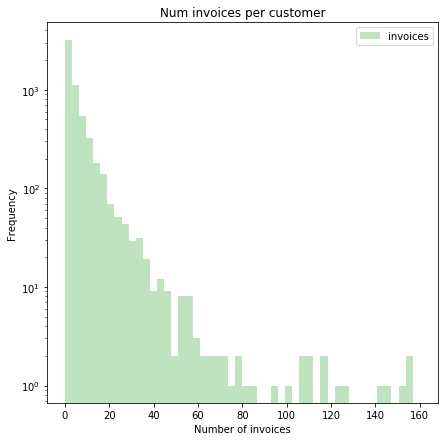

In [13]:
df_customer_invoices  = df.groupby('Customer_ID').Invoice.unique().agg([len])     \
                         .rename(columns={"len": "invoices"})               \
                         .sort_values(by=['invoices'],ascending=False)

tit='Num invoices per customer'
r=(0,160)
df_customer_invoices.plot(kind='hist',logy=True, \
                          title=tit,bins=50,range=r,colormap='Accent',alpha=0.5,figsize=(7,7))
plt.xlabel('Number of invoices') 
df_customer_invoices.describe()

,items,invoices_cl,itemsPerInvoice
count,5875.000000,5875.000000,5875.000000
mean,137.109787,6.288511,22.174606
std,353.873267,12.994839,19.847371
min,1.000000,1.000000,1.000000
25%,21.000000,1.000000,10.000000
50%,53.000000,3.000000,17.500000
75%,142.500000,7.000000,28.000000
max,12890.000000,396.000000,300.470588


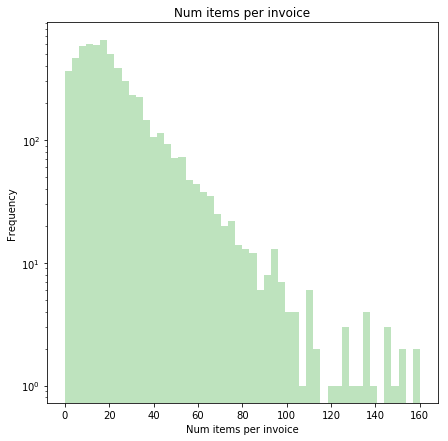

In [14]:
df_customer_items['invoices_cl'] = df_customer_invoices['invoices']
df_customer_items['itemsPerInvoice'] = df_customer_items['items']/df_customer_items['invoices_cl']

df_customer_items.head()

tit='Num items per invoice'
r=(0,160)
df_customer_items.itemsPerInvoice.plot(kind='hist',logy=True, \
                          title=tit,bins=50,range=r,colormap='Accent',alpha=0.5,figsize=(7,7))
plt.xlabel('Num items per invoice') 
df_customer_items.describe()

,total_spent
count,5875.000000
mean,3001.641824
std,14678.849010
min,2.950000
25%,348.195000
50%,896.660000
75%,2302.480000
max,608821.650000


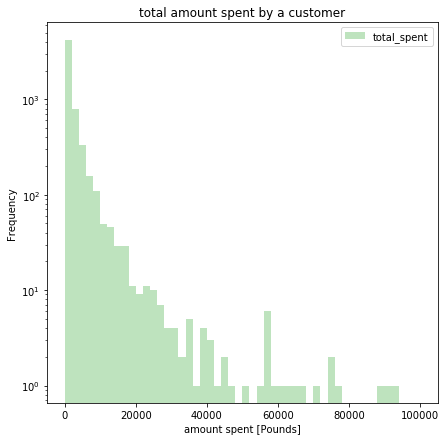

In [15]:
df_customer_spent = df.groupby('Customer_ID').Transaction.agg([sum])     \
                   .rename(columns={"sum": "total_spent"})               \
                   .sort_values(by=['total_spent'],ascending=False)

tit='total amount spent by a customer'
r=(0,100000)
df_customer_spent.plot(kind='hist',logy=True,title=tit, \
                       bins=50,range=r,colormap='Accent',alpha=0.5,figsize=(7,7))
plt.xlabel('amount spent [Pounds]') 
df_customer_spent.describe()

In [16]:
df_customer_spent.sort_values(by=['Customer_ID'],ascending=True).head()

,total_spent
Customer_ID,
12346.0,77556.46
12347.0,5633.32
12348.0,2019.40
12349.0,4428.69
12350.0,334.40


In [17]:
df.loc[ (df.Customer_ID==12346) &  (df.Quantity<100000)].Transaction.sum()

77556.46

In [18]:
# validation by spot checks: on a few specific customers to ensure there's no bugs
df.loc[ (df.Customer_ID==12346)]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer_ID,Country,Transaction,InvoiceDay,InvoiceWeekDay,InvoiceTime,InvoiceWeek,IsCancellation,IsOrdinaryItem
27994,491725,TEST001,This is a test product.,10,2009-12-14 08:34:00,4.50,12346.0,United Kingdom,45.00,2009-12-14,0,08:34:00,2,0,1
28251,491742,TEST001,This is a test product.,5,2009-12-14 11:00:00,4.50,12346.0,United Kingdom,22.50,2009-12-14,0,11:00:00,2,0,1
28254,491744,TEST001,This is a test product.,5,2009-12-14 11:02:00,4.50,12346.0,United Kingdom,22.50,2009-12-14,0,11:02:00,2,0,1
39398,492718,TEST001,This is a test product.,5,2009-12-18 10:47:00,4.50,12346.0,United Kingdom,22.50,2009-12-18,4,10:47:00,2,0,1
39411,492722,TEST002,This is a test product.,1,2009-12-18 10:55:00,1.00,12346.0,United Kingdom,1.00,2009-12-18,4,10:55:00,2,0,1
45228,493410,TEST001,This is a test product.,5,2010-01-04 09:24:00,4.50,12346.0,United Kingdom,22.50,2010-01-04,0,09:24:00,4,0,1
45230,493412,TEST001,This is a test product.,5,2010-01-04 09:53:00,4.50,12346.0,United Kingdom,22.50,2010-01-04,0,09:53:00,4,0,1
56117,494450,TEST001,This is a test product.,5,2010-01-14 13:50:00,4.50,12346.0,United Kingdom,22.50,2010-01-14,3,13:50:00,5,0,1
66084,495295,TEST001,This is a test product.,5,2010-01-22 13:30:00,4.50,12346.0,United Kingdom,22.50,2010-01-22,4,13:30:00,6,0,1
107803,499763,15056BL,EDWARDIAN PARASOL BLACK,1,2010-03-02 13:08:00,5.95,12346.0,United Kingdom,5.95,2010-03-02,1,13:08:00,12,0,1


In [19]:
df.loc[ (df.Customer_ID==12346)].InvoiceDay.unique().shape
# verification of 'fequency' being equal to 7 for 12346
# remiminder: the RFM variables exclude the first invoice

(8,)

# Historic customer  features

## The literature is rich in models and prescriptions
- see for instance: https://www.blastanalytics.com/blog/rfm-analysis-boosts-sales
- and https://joaocorreia.io/blog/rfm-analysis-increase-sales-by-segmenting-your-customers.html

## to characterise customers according to three simple historical variables 
- **Recency**: How recently a customer has made a purchase
- **Frequency**: How often a customer makes a purchase
- **Monetary Value**: Average expenditure for an invoice

# Notes
- RFM variables exlcude the first invoice for all customers. Only returning invoices are considered
- note2: values=0 are for customers that don't return => select those customers away to consider

# Preparation of data: two attempts to cluster customers

In [20]:
# pip install --user lifetimes
print('pip install worked out fine')

pip install worked out fine


In [21]:
data_star='2009-12-01'
calib_end='2011-05-31'
obser_end='2011-12-09'

from datetime import date
d_data_star=date( * map(lambda u:int(u), data_star.split('-') ) )
d_calib_end=date( * map(lambda u:int(u), calib_end.split('-') ) )
d_obser_end=date( * map(lambda u:int(u), obser_end.split('-') ) )

from lifetimes.utils import *

#    This transforms a DataFrame of transaction data of the form:
#        customer_id, datetime [, monetary_value]
#    to a DataFrame of the form:
#        customer_id, frequency, recency, T [, monetary_value]

df_customer_RFM = summary_data_from_transaction_data(df.sort_values(by=['InvoiceDate'],ascending=True)
                                                     ,'Customer_ID','InvoiceDate'
                                                     ,monetary_value_col='Transaction'
                                                     ,freq='D'
                                                     #,observation_period_end=obser_end
                                                    )

In [22]:
df_customer_RFM.head()

,frequency,recency,T,monetary_value
Customer_ID,,,,
12346.0,7.0,400.0,725.0,11066.637143
12347.0,7.0,402.0,404.0,717.398571
12348.0,4.0,363.0,438.0,449.310000
12349.0,3.0,571.0,589.0,1120.056667
12350.0,0.0,0.0,310.0,0.000000


count      4188.000000
mean        444.852285
std        2659.563745
min           3.900000
25%         191.527813
50%         306.254500
75%         452.696250
max      168469.600000
Name: monetary_value, dtype: float64

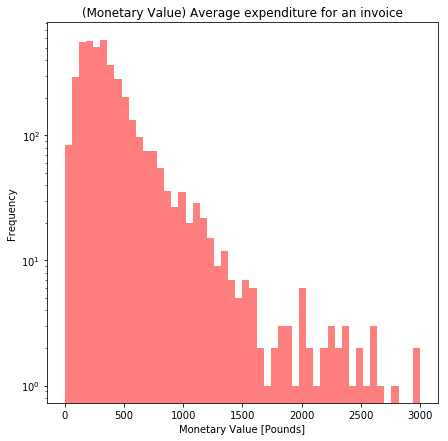

In [75]:
tit='(Monetary Value) Average expenditure for an invoice'
r=(0,3000)
df_customer_RFM['monetary_value'].loc[df_customer_RFM['monetary_value']>0]  \
                                 .plot(kind='hist',logy=True,title=tit,     \
                                       bins=50,range=r,colormap='autumn',alpha=0.5,figsize=(7,7))

plt.xlabel('Monetary Value [Pounds]') 
df_customer_RFM['monetary_value'].loc[df_customer_RFM['monetary_value']>0].describe()

count    4188.000000
mean      383.652579
std       227.629943
min         1.000000
25%       176.000000
50%       387.000000
75%       592.000000
max       738.000000
Name: recency, dtype: float64

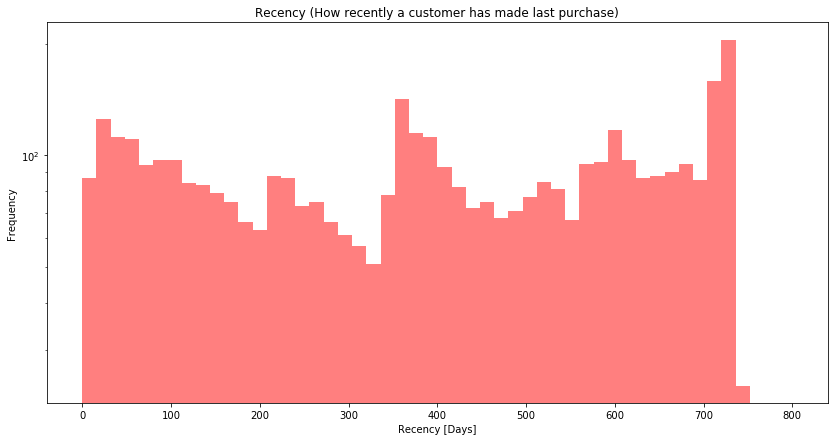

In [76]:
tit='Recency (How recently a customer has made last purchase)'
r=(0,800)
df_customer_RFM['recency'].loc[df_customer_RFM['recency']>0] \
     .plot(kind='hist',logy=True,title=tit,bins=50,          \
           range=r,colormap='autumn',alpha=0.5,figsize=(14,7))
plt.xlabel('Recency [Days]') 
df_customer_RFM['recency'].loc[df_customer_RFM['recency']>0].describe()

count    4188.000000
mean        6.499522
std        11.313255
min         1.000000
25%         2.000000
50%         3.000000
75%         7.000000
max       253.000000
Name: frequency, dtype: float64

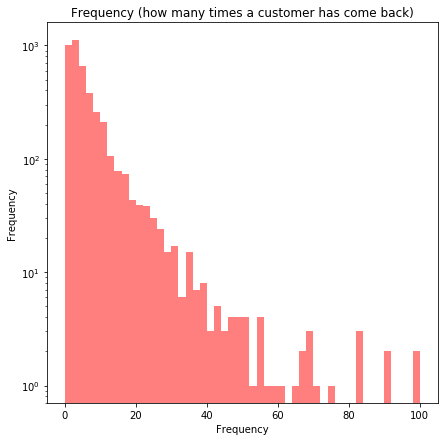

In [69]:
tit='Frequency (how many times a customer has come back)'
r=(0,100)
df_customer_RFM['frequency'].loc[df_customer_RFM['frequency']>0] \
           .plot(kind='hist',logy=True,title=tit,bins=50,range=r,colormap='autumn',alpha=0.5,figsize=(7,7))
plt.xlabel('Frequency') 
df_customer_RFM['frequency'].loc[df_customer_RFM['frequency']>0].describe()

In [65]:
df_customer = df_customer_items     \
                .join(df_customer_invoices)    \
                .join(df_customer_spent)   \
                .join(df_customer_RFM)   \
            .sort_values(by=['total_spent'],ascending=False)

df_customer.shape
df_customer.head()

,items,invoices_cl,itemsPerInvoice,invoices,total_spent,frequency,recency,T,monetary_value
Customer_ID,,,,,,,,,
18102.0,1058,145,7.296552,145,608821.65,66.0,738.0,738.0,9189.930455
14646.0,3849,151,25.490066,151,528602.52,90.0,736.0,737.0,5809.905333
14156.0,4046,154,26.272727,154,308664.36,119.0,729.0,738.0,2584.853445
14911.0,11243,396,28.391414,396,292598.29,253.0,737.0,738.0,1153.615257
17450.0,424,51,8.313725,51,246973.09,30.0,430.0,438.0,6924.523000


In [66]:
df_customer.shape

(5875, 9)

# consider only returning customers
- Keep the model simple and don''t treat customers who have never come back => require frequency and recency to be positive

In [28]:
df_customer = df_customer.loc[df_customer['monetary_value']>0]   \
                    .loc[df_customer['recency']>0]          \
                    .loc[df_customer['frequency']>0]        \

In [29]:
print('There are %d RETURNING customers in the cleaned dataset'%df_customer['monetary_value'].count() )
df_customer.shape

There are 4188 RETURNING customers in the cleaned dataset


(4188, 9)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd376e51a50>,
      dtype=object)

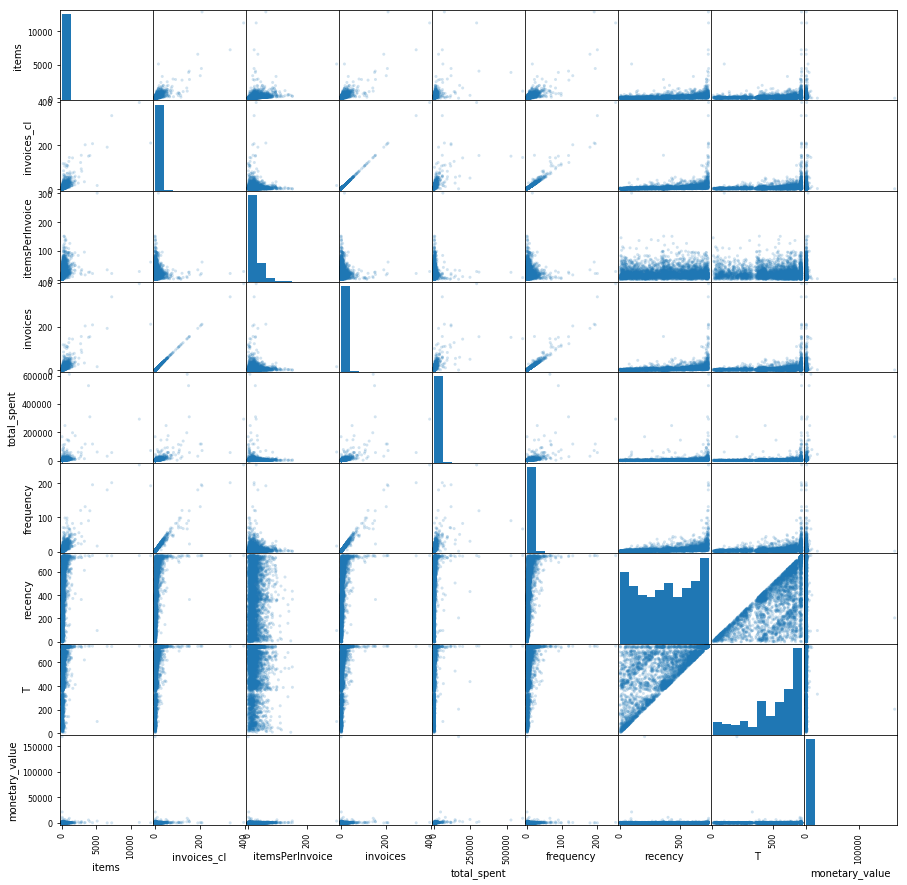

In [30]:
pd.plotting.scatter_matrix(df_customer, alpha=0.2,figsize=(15,15))

In [31]:
# cut_out=0.02
# q_low = df_customer["monetary_value"].quantile(cut_out)
# q_hi  = df_customer["monetary_value"].quantile(1-cut_out)
# df_customer = df_customer[(df_customer["monetary_value"] < q_hi) & (df_customer["monetary_value"] > q_low)]
# df_customer.shape

In [32]:
df_customer.corr()

,items,invoices_cl,itemsPerInvoice,invoices,total_spent,frequency,recency,T,monetary_value
items,1.000000,0.798900,0.322310,0.798900,0.460331,0.801204,0.292752,0.176818,0.027191
invoices_cl,0.798900,1.000000,-0.015270,1.000000,0.624470,0.966786,0.377029,0.249447,0.033921
itemsPerInvoice,0.322310,-0.015270,1.000000,-0.015270,0.012665,-0.008878,0.043283,-0.038120,0.014975
invoices,0.798900,1.000000,-0.015270,1.000000,0.624470,0.966786,0.377029,0.249447,0.033921
total_spent,0.460331,0.624470,0.012665,0.624470,1.000000,0.548049,0.187716,0.122081,0.249806
frequency,0.801204,0.966786,-0.008878,0.966786,0.548049,1.000000,0.423773,0.273822,0.023363
recency,0.292752,0.377029,0.043283,0.377029,0.187716,0.423773,1.000000,0.710618,0.009709
T,0.176818,0.249447,-0.038120,0.249447,0.122081,0.273822,0.710618,1.000000,-0.007027
monetary_value,0.027191,0.033921,0.014975,0.033921,0.249806,0.023363,0.009709,-0.007027,1.000000


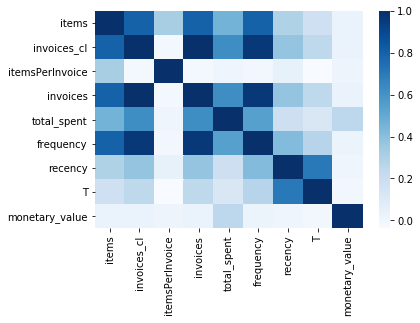

In [33]:
import seaborn as sns

sns.heatmap(df_customer.drop([],axis=1).corr(),cmap="Blues")

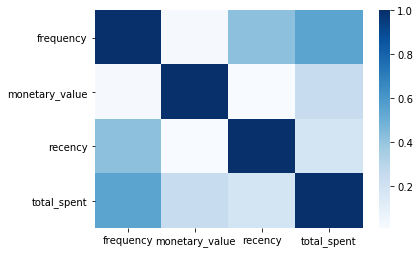

In [34]:
sns.heatmap(df_customer[['frequency','monetary_value','recency','total_spent']].corr(),cmap="Blues")

## add logarithm of features
- to better surface the relevance of features which are distributed exponentially
- otherwise the constraining power of most features remains hidden are otherwise hidden

In [35]:
import numpy as np


do_log = True
if do_log:
    df_customer['monetary_value_log'] = np.log(df_customer['monetary_value'])
    df_customer['frequency_log'] = np.log(df_customer['frequency'])
    df_customer['total_spent_log'] = np.log(df_customer['total_spent'])

In [36]:
# Importing the dataset
# df_customer_km = df_customer.drop(['Customer_ID'],axis=0)

mat_customer_km = df_customer[['frequency_log','recency','monetary_value_log','total_spent_log']]
mat_customer_km.head()

,frequency_log,recency,monetary_value_log,total_spent_log
Customer_ID,,,,
18102.0,4.189655,738.0,9.125864,13.319281
14646.0,4.499810,736.0,8.667320,13.177992
14156.0,4.779123,729.0,7.857424,12.640010
14911.0,5.533389,737.0,7.050656,12.586556
17450.0,3.401197,430.0,8.842824,12.417035


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd30f23a5d0>,
      dtype=object)

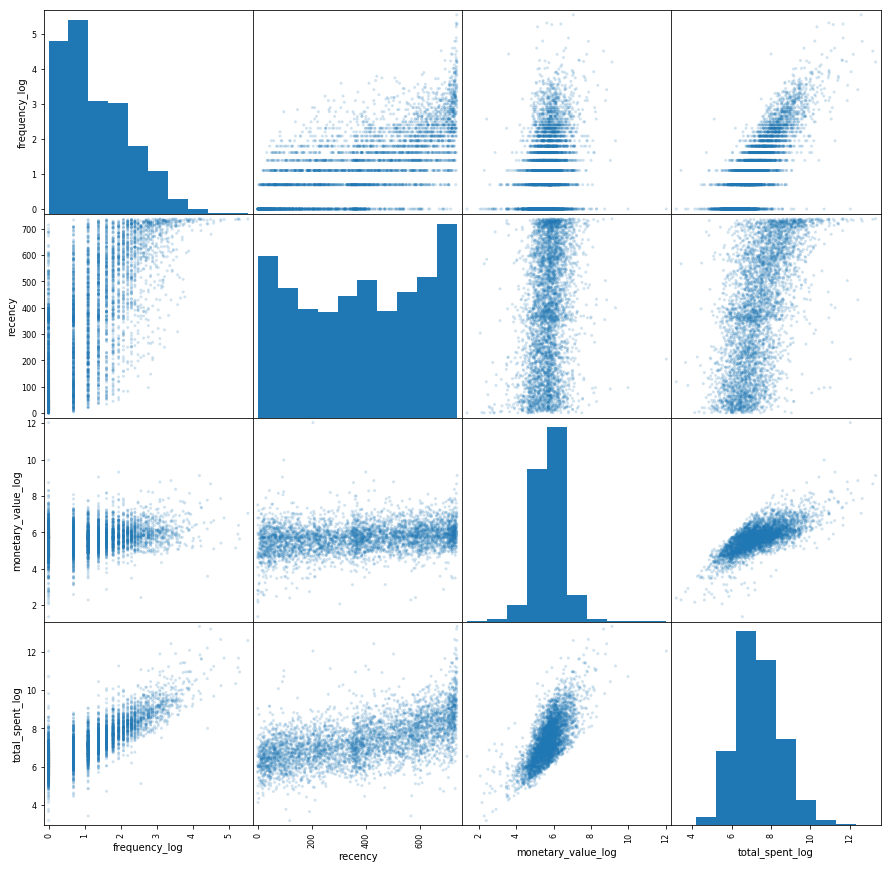

In [37]:
pd.plotting.scatter_matrix(df_customer[['frequency_log','recency','monetary_value_log','total_spent_log']], alpha=0.2,figsize=(15,15))

# BASIC grouping of customers
- cut-and-count method using RFM variables

In [38]:
# https://www.blastanalytics.com/blog/rfm-analysis-boosts-sales
# https://joaocorreia.io/blog/rfm-analysis-increase-sales-by-segmenting-your-customers.html

In [39]:
# functions to assign quantile bins, for the case of 4 and 3 bins

# such that 1/4 score means best/worst customer feature
def scoring_four(x,p,d,invert):
    """ the last argument in the API flips the order of the score,
        such that LARGE score always means GOOD customer feature"""
    if x <= d[p][0.25]:
        return 1 if invert else 4
    elif x <= d[p][0.50]:
        return 2 if invert else 3
    elif x <= d[p][0.75]: 
        return 3 if invert else 2
    else:
        return 4 if invert else 1

# such that 1/3 score means best/worst customer feature
def scoring_three(x,p,d,invert):
    """ the last argument in the API flips the order of the score,
        such that LARGE score always means GOOD customer feature"""
    if x <= d[p][0.33]:
        return 1 if invert else 3
    elif x <= d[p][0.66]:
        return 2 if invert else 2
    else:
        return 3 if invert else 1

In [40]:
quantiles = df_customer.quantile(q=[0.25,0.5,0.75])
quantiles

,items,invoices_cl,itemsPerInvoice,invoices,total_spent,frequency,recency,T,monetary_value,monetary_value_log,frequency_log,total_spent_log
0.25,41.0,3.0,10.666667,3.0,721.7925,2.0,176.0,408.75,191.527813,5.255033,0.693147,6.581737
0.50,87.0,5.0,17.827381,5.0,1419.4000,3.0,387.0,589.00,306.254500,5.724416,1.098612,7.257989
0.75,201.0,9.0,28.170940,9.0,3279.7125,7.0,592.0,688.00,452.696250,6.115221,1.945910,8.095511


In [41]:
quantiles = df_customer.quantile(q=[0.33,0.66])
quantiles

,items,invoices_cl,itemsPerInvoice,invoices,total_spent,frequency,recency,T,monetary_value,monetary_value_log,frequency_log,total_spent_log
0.33,53.00,3.0,13.0,3.0,910.3036,2.0,247.71,450.0,227.545536,5.427350,0.693147,6.813778
0.66,145.42,7.0,23.5,7.0,2363.7962,5.0,521.00,659.0,383.546400,5.949461,1.609438,7.768024


In [42]:
quantiles_d = quantiles.to_dict()
#quantiles_d 

In [43]:
df_customer['recency_score']   = df_customer['recency']             .apply(scoring_three, args=('recency',quantiles,True))
df_customer['frequency_score'] = df_customer['frequency']           .apply(scoring_three, args=('frequency',quantiles,False))
df_customer['monetary_value_score'] = df_customer['monetary_value'] .apply(scoring_three, args=('monetary_value',quantiles,False))

In [44]:
df_customer.head(5)

,items,invoices_cl,itemsPerInvoice,invoices,total_spent,frequency,recency,T,monetary_value,monetary_value_log,frequency_log,total_spent_log,recency_score,frequency_score,monetary_value_score
Customer_ID,,,,,,,,,,,,,,,
18102.0,1058,145,7.296552,145,608821.65,66.0,738.0,738.0,9189.930455,9.125864,4.189655,13.319281,3,1,1
14646.0,3849,151,25.490066,151,528602.52,90.0,736.0,737.0,5809.905333,8.667320,4.499810,13.177992,3,1,1
14156.0,4046,154,26.272727,154,308664.36,119.0,729.0,738.0,2584.853445,7.857424,4.779123,12.640010,3,1,1
14911.0,11243,396,28.391414,396,292598.29,253.0,737.0,738.0,1153.615257,7.050656,5.533389,12.586556,3,1,1
17450.0,424,51,8.313725,51,246973.09,30.0,430.0,438.0,6924.523000,8.842824,3.401197,12.417035,2,1,1


In [45]:
df_customer.groupby(['recency_score','frequency_score','monetary_value_score'], sort = True).T.agg(len)

recency_score  frequency_score  monetary_value_score
1              1                1                        23.0
                                2                        30.0
                                3                        22.0
               2                1                        64.0
                                2                       115.0
                                3                       123.0
               3                1                       240.0
                                2                       292.0
                                3                       473.0
2              1                1                       126.0
                                2                       133.0
                                3                        94.0
               2                1                       162.0
                                2                       180.0
                                3                       161.0
               3 

In [46]:
df_customer.groupby(['monetary_value_score','recency_score',], sort = True) \
    .T.agg(len)

monetary_value_score  recency_score
1                     1                327.0
                      2                453.0
                      3                644.0
2                     1                437.0
                      2                478.0
                      3                467.0
3                     1                618.0
                      2                452.0
                      3                312.0
Name: T, dtype: float64

In [47]:
type(df_customer.groupby(['monetary_value_score','frequency_score',], sort = True).T.agg(len))

pandas.core.series.Series

## Customer clustering: k-mean

('For n_clusters =', 2, 'The average silhouette_score is :', 0.6229212438194084)
('For n_clusters =', 3, 'The average silhouette_score is :', 0.6227941420583869)
('For n_clusters =', 4, 'The average silhouette_score is :', 0.5922355162483339)
('For n_clusters =', 5, 'The average silhouette_score is :', 0.5926171852967373)
('For n_clusters =', 6, 'The average silhouette_score is :', 0.5852302961935669)
('For n_clusters =', 7, 'The average silhouette_score is :', 0.5808540360653288)
('For n_clusters =', 8, 'The average silhouette_score is :', 0.5690297294034006)
('For n_clusters =', 9, 'The average silhouette_score is :', 0.5665304176834293)
('For n_clusters =', 10, 'The average silhouette_score is :', 0.564151307978288)


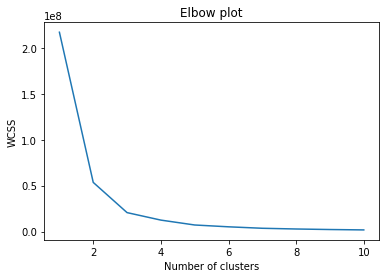

In [48]:
# Using the elbow method to find the optimal number of clusters
from sklearn.cluster import KMeans
from sklearn.metrics import  silhouette_score

wcss = []
mat_customer_km = mat_customer_km.as_matrix()

import matplotlib.pyplot as plt

for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(mat_customer_km)
    clusters = kmeans.predict(mat_customer_km)
    if i>1:
        silhouette_avg = silhouette_score(mat_customer_km, clusters)
        print("For n_clusters =", i, "The average silhouette_score is :", silhouette_avg)

    wcss.append(kmeans.inertia_)
    
plt.plot(range(1, 11), wcss)
plt.title('Elbow plot')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

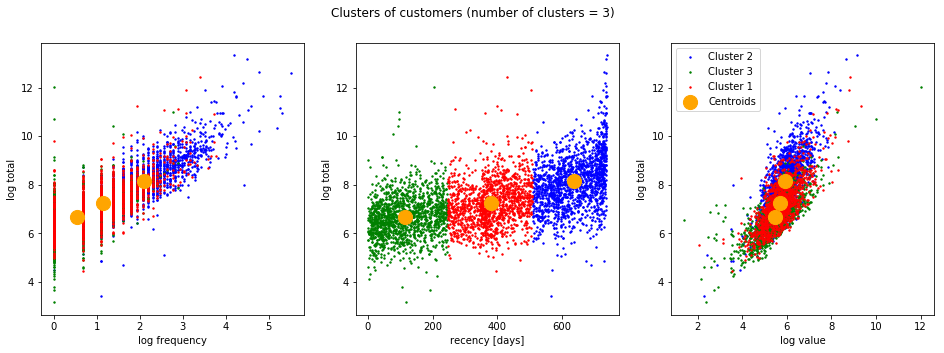

In [49]:
X=mat_customer_km
# Fitting K-Means to the dataset
how_many_clusters = 3

kmeans = KMeans(n_clusters = how_many_clusters, init = 'k-means++', random_state = 42)
y_kmeans = kmeans.fit_predict(X)


# 0: frequency
# 1: recency
# 2: value
# 3: total
labels = ['log frequency','recency [days]','log value','log total']

fig, axs = plt.subplots(1,3)
fig.set_figheight(5)
fig.set_figwidth(16)
fig.suptitle('Clusters of customers (number of clusters = %d)'%how_many_clusters)

for x_index,y_index,u in [[0,3,0],[1,3,1],[2,3,2]]:
    
    # Visualising the clusters
    axs[u].scatter( X[y_kmeans == 1, x_index], X[y_kmeans == 1, y_index], s = 2, c = 'blue', label = 'Cluster 2')
    axs[u].scatter( X[y_kmeans == 2, x_index], X[y_kmeans == 2, y_index], s = 2, c = 'green', label = 'Cluster 3')
    axs[u].scatter( X[y_kmeans == 0, x_index], X[y_kmeans == 0, y_index], s = 2, c = 'red', label = 'Cluster 1')

    #axs[u].scatter(X[y_kmeans == 3, x_index], X[y_kmeans == 3, y_index], s = 2, c = 'cyan', label = 'Cluster 4')
    #axs[u].scatter(X[y_kmeans == 4, x_index], X[y_kmeans == 4, y_index], s = 2, c = 'magenta', label = 'Cluster 5')

    # barycenters and labels
    axs[u].scatter(kmeans.cluster_centers_[:, x_index], kmeans.cluster_centers_[:, y_index], s = 200, c = 'orange', label = 'Centroids')

    axs[u].set_xlabel(labels[x_index])
    axs[u].set_ylabel(labels[y_index])
    plt.legend()

## interpretation
- Customers in cluster number 2 have shopped long ago ( at least 500 days before the end of the period covered by the data) and have the largest shopping frequency and total expenditure
- Customers in cluster number 3 have shopped most recently (at most 250 days ago) and tend to have a low shopping frequency (both visible in the first plot, and the the third where total/averag expenditure is low)
- Customers in cluster number 1 have an intermediate behaviour both in terms of recency (between 250 and 500) and frequency

In [50]:
y_kmeans 

array([1, 1, 1, ..., 2, 1, 2], dtype=int32)

In [51]:
kmeans.cluster_centers_

array([[1.15262876e+00, 3.79438304e+02, 5.70798118e+00, 7.24460885e+00],
       [2.09444826e+00, 6.37129530e+02, 5.90095091e+00, 8.15621374e+00],
       [5.36117519e-01, 1.13417574e+02, 5.47265225e+00, 6.66773604e+00]])

In [52]:
# freq
X[:,0]

array([4.18965474, 4.49980967, 4.77912349, ..., 0.        , 1.09861229,
       0.        ])

In [53]:
# recency
X[:,1]

array([738., 736., 729., ..., 192., 567., 119.])

In [54]:
# value
X[:,2]

array([9.12586365, 8.66731956, 7.85742409, ..., 2.73696154, 2.28238239,
       2.38876279])

In [55]:
X[0,:]

array([  4.18965474, 738.        ,   9.12586365,  13.31928065])